In [1]:
#import mathematics statics libraries
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
from tensorflow import keras


In [2]:
#load mnist datasets
(inp_tn, out_tn), (inp_ts, out_ts) = keras.datasets.mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


In [3]:
#expand mnist dimensions
inp_tn = inp_tn.reshape(-1,28,28,1)
inp_ts = inp_ts.reshape(-1,28,28,1)


In [4]:
#create model function
def create_model(inp_shape,
                 conv_layers_num, conv_filters, conv_kernel_size,
                 dense_layers_num, dense_drop_ratio, dense_units,
                 out_drop_ratio, out_units, out_activation,
                 optimizer, loss , metric,
                 #layers batch drop configuration
                 conv_base = True, dense_head = True,
                 batch_norm_conv = True, batch_norm_dense = True, batch_norm_out = True,
                 drop_dense = True, drop_out = True,
                 #layers activation
                 conv_activation = 'relu', dense_activation = 'relu'):
    
    model = keras.Sequential()
    
    #define input layer
    model.add(keras.layers.InputLayer(input_shape = inp_shape))

    #define convolution layers
    if conv_base:
        for i in range(conv_layers_num):
            if batch_norm_conv:
                model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Conv2D(filters = conv_filters[i],
                                          kernel_size = conv_kernel_size[i], activation = conv_activation,
                                          kernel_initializer = keras.initializers.HeNormal()))
            model.add(keras.layers.MaxPool2D())

    #convert two dims to one dim
    model.add(keras.layers.Flatten())

    #define dense layers
    if dense_head:
        for i in range(dense_layers_num):
            if batch_norm_dense:
                model.add(keras.layers.BatchNormalization())
            if drop_dense:
                model.add(keras.layers.Dropout(dense_drop_ratio[i]))
            model.add(keras.layers.Dense(units = dense_units[i], activation = dense_activation,
                                         kernel_initializer = keras.initializers.HeNormal()))

    #define output layers
    if batch_norm_out:
        model.add(keras.layers.BatchNormalization())
    if drop_out:
        model.add(keras.layers.Dropout(out_drop_ratio))
    model.add(keras.layers.Dense(units = out_units, activation = out_activation))

    #define model compile
    model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metric)

    return model


In [5]:
#define custom callbacks
class callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs['accuracy'] >= 0.9990 or logs['val_accuracy'] >= 0.9990 :
            self.model.stop_training = True


In [6]:
model = create_model(inp_shape=(28,28,1),
                     conv_layers_num = 2, conv_filters = [128, 128], conv_kernel_size = [3, 3],
                     dense_layers_num = 2, dense_drop_ratio = [0.3, 0.3], dense_units = [256, 256],
                     #use only convolution base without dense head
                     conv_base = True, dense_head = False,
                     out_drop_ratio = 0.3, out_units = 10, out_activation = 'softmax',
                     optimizer = 'adam', loss = 'sparse_categorical_crossentropy' , metric = 'accuracy',
                     batch_norm_conv = True, batch_norm_dense = True, batch_norm_out = True,
                     drop_dense = False, drop_out = False,)


In [7]:
#print model summary
model.summary(120)


Model: "sequential"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 batch_normalization (BatchNormalization)             (None, 28, 28, 1)                               4                 
                                                                                                                        
 conv2d (Conv2D)                                      (None, 26, 26, 128)                             1280              
                                                                                                                        
 max_pooling2d (MaxPooling2D)                         (None, 13, 13, 128)                             0                 
                                                                                                                        
 batch_norma

In [8]:
#fit model for training
history = model.fit(x = inp_tn, y = out_tn, epochs = 100, batch_size = 64, validation_data = (inp_ts, out_ts),
                    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True),
                                 keras.callbacks.CSVLogger('Logs.csv'), callback()])


Epoch 1/100
938/938 [==============================] - 225s 237ms/step - loss: 0.1161 - accuracy: 0.9657 - val_loss: 0.0698 - val_accuracy: 0.9795
Epoch 2/100
938/938 [==============================] - 211s 225ms/step - loss: 0.0643 - accuracy: 0.9823 - val_loss: 0.0691 - val_accuracy: 0.9809
Epoch 3/100
938/938 [==============================] - 211s 225ms/step - loss: 0.0521 - accuracy: 0.9862 - val_loss: 0.0456 - val_accuracy: 0.9889
Epoch 4/100
938/938 [==============================] - 211s 225ms/step - loss: 0.0365 - accuracy: 0.9901 - val_loss: 0.0768 - val_accuracy: 0.9837
Epoch 5/100
938/938 [==============================] - 211s 225ms/step - loss: 0.0347 - accuracy: 0.9905 - val_loss: 0.0644 - val_accuracy: 0.9845
Epoch 6/100
938/938 [==============================] - 211s 225ms/step - loss: 0.0274 - accuracy: 0.9925 - val_loss: 0.0740 - val_accuracy: 0.9847
Epoch 7/100
938/938 [==============================] - 212s 226ms/step - loss: 0.0232 - accuracy: 0.9936 - val_loss: 0

In [9]:
#plot training history
hist_frame = pd.DataFrame(history.history)


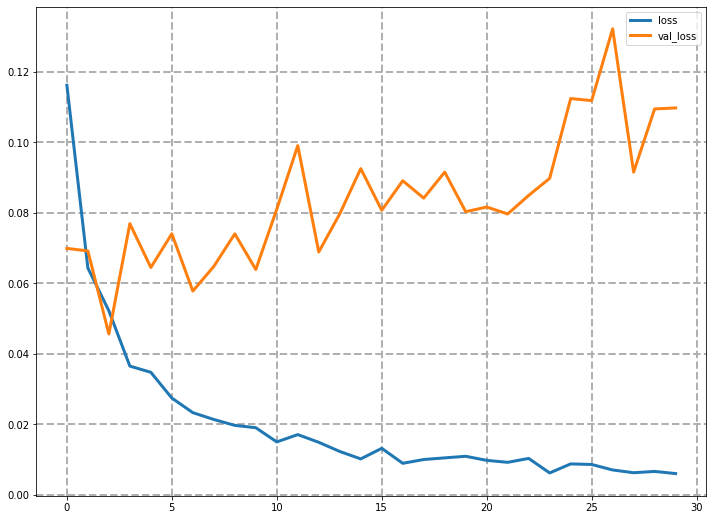

In [10]:
#plot loss
hist_frame[['loss', 'val_loss']].plot(figsize = (12,9), linewidth = 3)
plt.grid(linewidth = 2, linestyle = '--')


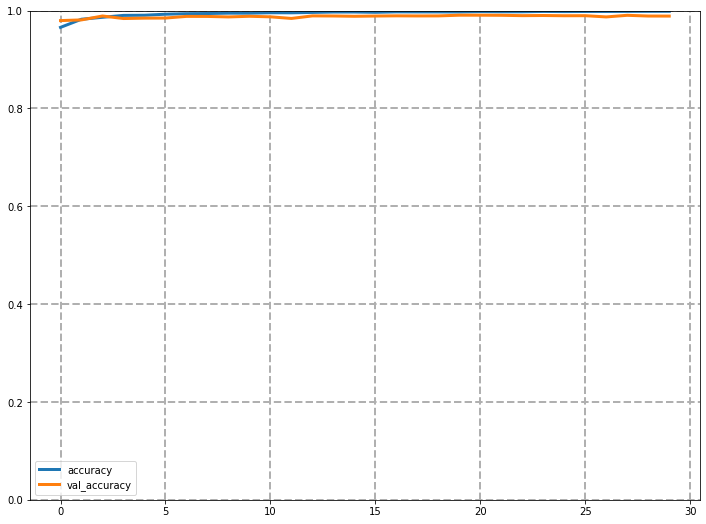

In [11]:
#plot accuracy
hist_frame[['accuracy', 'val_accuracy']].plot(figsize = (12,9), linewidth = 3)
plt.ylim(0,1)
plt.grid(linewidth = 2, linestyle = '--')


In [12]:
np.set_printoptions(linewidth = 320)

#print model test prediction
pred_ts = pd.DataFrame(model.predict(inp_ts))
count_pred_ts = (pred_ts.idxmax(axis = 1) == out_ts).value_counts()
print(count_pred_ts)

#print model test correct value counts
pred_ts.values

True     9905
False      95
dtype: int64


array([[2.0872644e-24, 1.3377794e-24, 1.4260621e-20, ..., 1.0000000e+00, 6.0757330e-29, 2.0474194e-21],
       [2.4545050e-25, 1.2266154e-21, 1.0000000e+00, ..., 2.8523328e-31, 1.8663716e-31, 3.5899069e-29],
       [3.1541067e-21, 1.0000000e+00, 1.4473034e-21, ..., 3.8631316e-12, 1.3054491e-17, 1.0247359e-19],
       ...,
       [0.0000000e+00, 3.2068129e-26, 0.0000000e+00, ..., 4.9113201e-27, 2.8732203e-26, 5.9791394e-30],
       [1.1339750e-29, 1.6158036e-36, 2.7476158e-32, ..., 7.7979464e-36, 1.4114165e-21, 1.8962854e-29],
       [7.5850291e-30, 9.4954117e-30, 3.5417060e-26, ..., 9.6099602e-34, 9.6803163e-25, 1.5483558e-25]], dtype=float32)

In [13]:
np.set_printoptions(linewidth = 320)

#print model train prediction
pred_tn = pd.DataFrame(model.predict(inp_tn))
count_pred_tn = (pred_tn.idxmax(axis = 1) == out_tn).value_counts()
print(count_pred_tn)

#print model train correct value counts
pred_tn.values

True     59928
False       72
dtype: int64


array([[7.1771747e-29, 6.3787123e-30, 9.6176811e-30, ..., 1.6985993e-23, 4.0476073e-20, 1.4834954e-16],
       [1.0000000e+00, 7.9284733e-24, 1.0187061e-12, ..., 2.6127614e-29, 1.3363305e-17, 8.0532997e-16],
       [6.8461430e-33, 1.9373962e-18, 1.4146887e-28, ..., 1.8875546e-27, 4.5576032e-21, 5.9733021e-23],
       ...,
       [7.4013969e-34, 9.2695875e-28, 0.0000000e+00, ..., 0.0000000e+00, 1.6294091e-28, 8.1216971e-16],
       [3.4686202e-27, 8.2508208e-24, 4.4180053e-28, ..., 2.1511563e-32, 5.1092586e-29, 1.0730925e-31],
       [5.2525973e-21, 1.7865215e-27, 2.3910201e-21, ..., 1.1083893e-25, 1.0000000e+00, 8.2520415e-18]], dtype=float32)

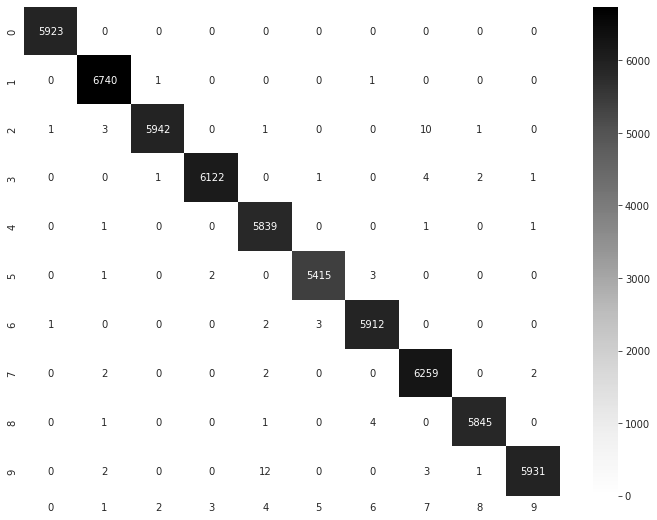

In [14]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (12,9))
sns.set_style('dark')
sns.heatmap(confusion_matrix(out_tn, pred_tn.idxmax(axis = 1)),
            annot = True, fmt = '.0f', cmap = 'Greys')


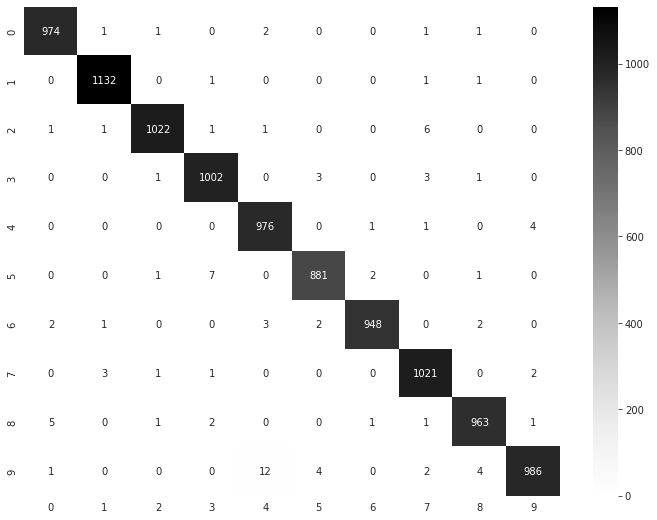

In [15]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (12,9))
sns.heatmap(confusion_matrix(out_ts, pred_ts.idxmax(axis = 1)),
            annot = True, fmt = '.0f', cmap = 'Greys')


In [17]:
#save model
model.save('digits-mnist-recognition-convolution-base.h5')
